# Predicting videogames sales through Bayesian reasoning
### Project carried out by [Diego Chinellato](https://github.com/diegochine) for the Fundamentals of AI and KR course - module 3

## Abstract
*Financial data, such as data representing sales of a certain asset in a given economic sector, is intrinsically imbued with uncertainty, due to both the uncertainty of the financial market as well as the noise present in the data itself. In this report, probabilistic reasoning tools are applied to financial data concerning the sales in the videogames market. First, four different Bayesian Networks models are constructed either by explicitly defining the structure or by inferring it from the data. Then, for each model parameters are learned from the available data. Finally, inference techniques are applied to perform probabilistic reasoning on the resulting model.*

This notebook describes the implementation of the Bayesian Network, as well as showing the queries and results.

## Data and preprocessing
*Dataset source: https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings*

This dataset contains a list of video games with sales greater than 100,000 copies. It was generated by a scrape of vgchartz.com.
Fields include:

* Name - The games name
* Platform - Platform of the games release (i.e. PC, PS4, etc.)
* Year - Year of the game's release
* Genre - Genre of the game
* Publisher - Publisher of the game
* NA_Sales - Sales in North America (in millions)
* EU_Sales - Sales in Europe (in millions)
* JP_Sales - Sales in Japan (in millions)
* Other_Sales - Sales in the rest of the world (in millions)
* Global_Sales - Total worldwide sales.
* Critic_score - Aggregate score compiled by Metacritic staff
* Critic_count - The number of critics used in coming up with the Criticscore
* User_score - Score by Metacritic's subscribers
* User_count - Number of users who gave the userscore
* Developer - Party responsible for creating the game
* Rating - The ESRB ratings

Before proceeding with the construction of the networks, we need to preprocess the data for several reasons:
* First, the are some features that have to be removed as they're not really helpful, such as the user and critic count which pretty much depend on the website from which the data was scraped from, or the name of the game. 
* Second, ``pmgpy`` unfortunately does not support learning of continuous variables, so all the non-discrete features in the dataset need to be discretized as well. 
* Finally, some data points representing for instance publishers or developers with a low number of games in the dataset were removed. Since there is already a huge number of unique values in these variables (which will, in turn, result in very big CDPs), this operation helps in having slightly smaller CDPs and to ease the general computational cost of the subsequent algorithms, while only slightly impacting the performances of the resulting networks.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion

In [2]:
df = pd.read_csv("videogames_sales.csv")
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

Dataset contains 16719 rows and 16 columns


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
discrete_bins = 5
freq_threshold = 4

data = df.drop(columns=['Name', 'User_Count', 'Critic_Count', 'Rating']).dropna()
data['Year'] = data['Year'].astype(np.uint16)
data.loc[data['User_Score'] == 'tbd', ('User_Score')] = data[data["User_Score"] != 'tbd']["User_Score"].astype(float).mean() # mean of the column 
data['User_Score'] = data['User_Score'].astype(np.float64)

# drop records with low counts to help discretization
data = data[data['Platform'] != 'DC']

#for drop_rating in ('RP', 'K-A', 'AO'):
#    data = data[data['Rating'] != drop_rating]
for discretize_col in ('NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'User_Score'):
    bins = pd.qcut(data[discretize_col], q=discrete_bins, duplicates='drop')
    bin2int = {x: i for i, x in enumerate(bins.dtype.categories)}
    data[discretize_col] = bins.apply(lambda x: bin2int[x]).astype(np.uint8)
publishers_to_drop = data['Publisher'].value_counts() > freq_threshold
data = data[publishers_to_drop[data['Publisher']].values]
developers_to_drop = data['Developer'].value_counts() > freq_threshold
data = data[developers_to_drop[data['Developer']].values]

In [4]:
print(f'Dataset contains {data.shape[0]} rows and {data.shape[1]} columns')
data.head()

Dataset contains 5806 rows and 12 columns


,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Developer
0,Wii,2006,Sports,Nintendo,4,4,1,3,4,3,3,Nintendo
2,Wii,2008,Racing,Nintendo,4,4,1,3,4,4,3,Nintendo
3,Wii,2009,Sports,Nintendo,4,4,1,3,4,3,3,Nintendo
6,DS,2006,Platform,Nintendo,4,4,1,3,4,4,4,Nintendo
7,Wii,2006,Misc,Nintendo,4,4,1,3,4,0,1,Nintendo


## Network definition


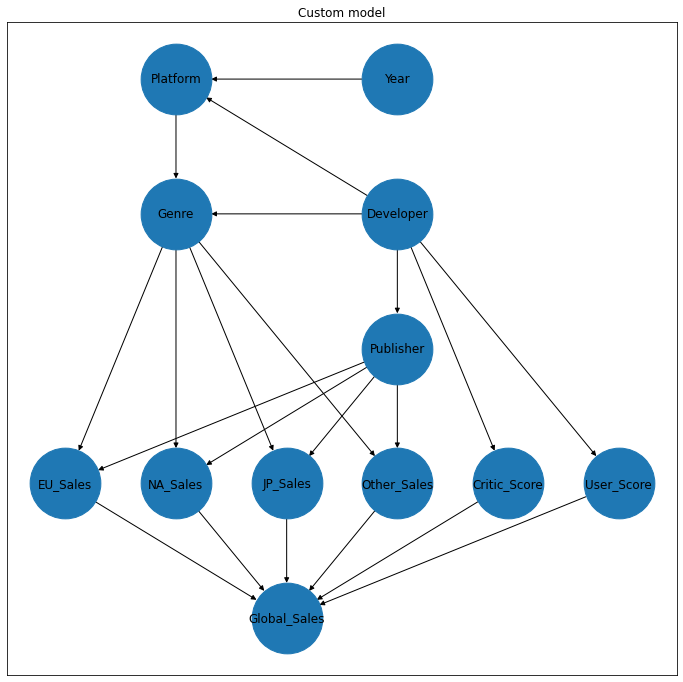

In [5]:
custom_model = BayesianModel([('Year', 'Platform'), ('Platform', 'Genre'),
                              ('Developer', 'Genre'), ('Developer', 'Platform'), ('Developer', 'Publisher'),
                              ('Publisher', 'EU_Sales'), ('Publisher', 'NA_Sales'), ('Publisher', 'JP_Sales'), ('Publisher', 'Other_Sales'),
                              ('Developer', 'Critic_Score'), ('Developer', 'User_Score'), ('Developer', 'Critic_Score'), ('Developer', 'User_Score'),
                              ('Genre', 'EU_Sales'), ('Genre', 'NA_Sales'), ('Genre', 'JP_Sales'), ('Genre', 'Other_Sales'), 
                              ('EU_Sales', 'Global_Sales'), ('NA_Sales', 'Global_Sales'), ('JP_Sales', 'Global_Sales'), ('Other_Sales', 'Global_Sales'),
                              ('Critic_Score', 'Global_Sales'), ('User_Score', 'Global_Sales')])
pos = {'Platform': [0.75, -0.5], 'Year': [1.25, -0.5],
       'Genre': [0.75, -1.], 'Developer': [1.25, -1],
       'Publisher': [1.25, -1.5],
       'Critic_Score': [1.5,  -2], 'User_Score': [1.75,  -2],
       'EU_Sales': [0.5, -2], 'NA_Sales': [0.75, -2], 'JP_Sales': [1, -2], 'Other_Sales': [1.25,  -2], 
       'Global_Sales': [1, -2.5]}
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')
fig.savefig('custom_bn')

## Learning the network structure

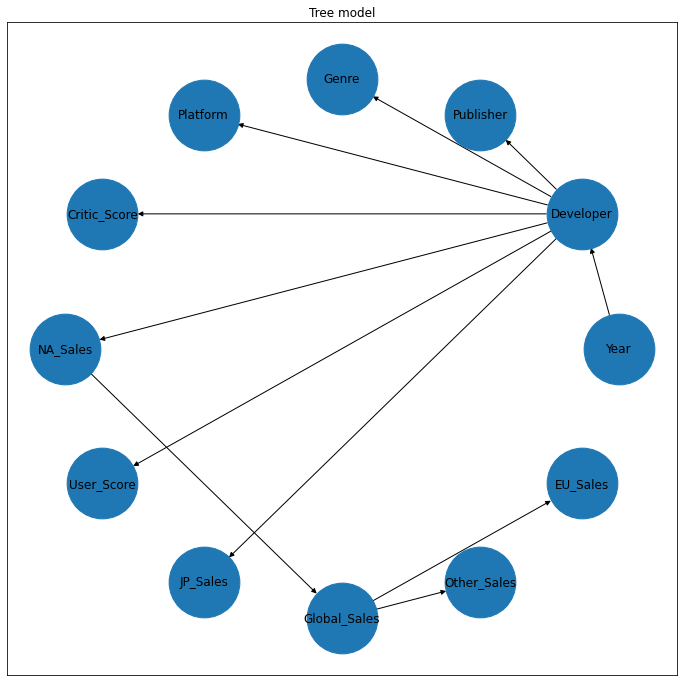

In [6]:
ts = TreeSearch(data=data, root_node='Year')
tree_model = ts.estimate(show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=5000)
fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

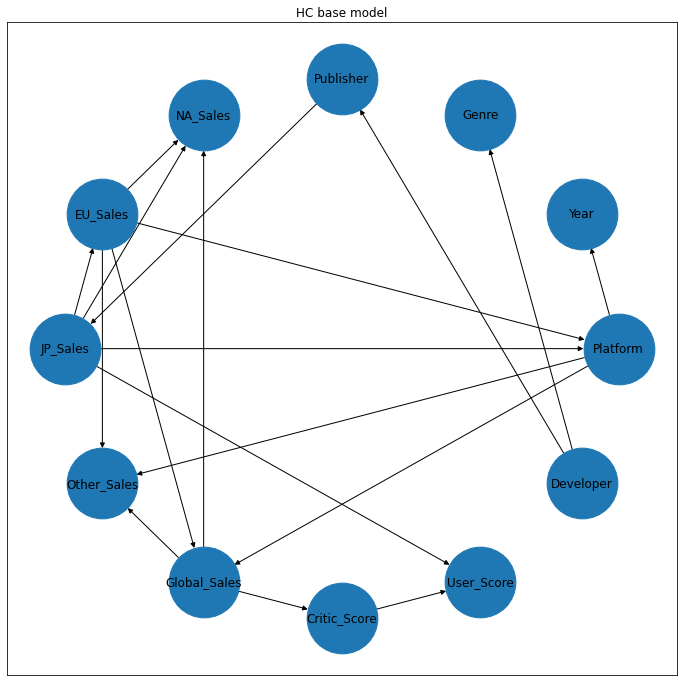

In [7]:
scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_base_model = hc.estimate(scoring_method=scorer, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.circular_layout(hc_base_model), ax=ax, node_size=5000)
fig.savefig('hc_base')
ax.set_title('HC base model')
hc_base_model = BayesianModel(hc_base_model.edges())

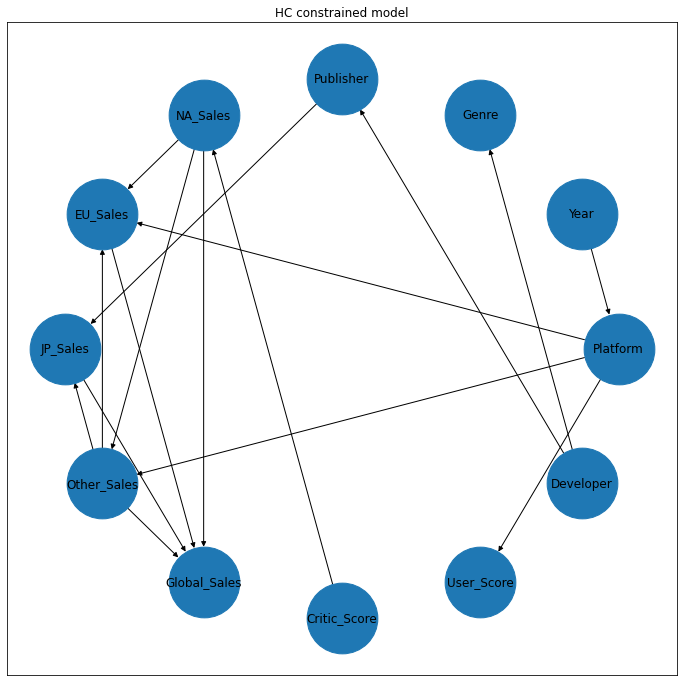

In [8]:
fixed_edges = [('EU_Sales', 'Global_Sales'), ('NA_Sales', 'Global_Sales'), 
               ('JP_Sales', 'Global_Sales'), ('Other_Sales', 'Global_Sales')]
black_list = [(f, 'Year') for f in data.columns] 
black_list += [('User_Score', 'Critic_Score'), ('Critic_Score', 'User_Score'), ('Publisher', 'Developer')]
black_list += [(sale, score) 
               for sale in ('EU_Sales', 'NA_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales')
               for score in ('User_Score', 'Critic_Score')]

scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_constr_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(hc_constr_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax, node_size=5000)
fig.savefig('hc_constrained')
ax.set_title('HC constrained model')
hc_constr_model = BayesianModel(hc_constr_model.edges())

## Learning the networks parameters (CDPs)

In [9]:
models = [('custom', custom_model), ('tree', tree_model), 
          ('hc base', hc_base_model), ('hc constrained', hc_constr_model)]
for name, model in models:
    print(f'Computing CDTs for {name} model')
    model.fit(data, estimator=MaximumLikelihoodEstimator)

Computing CDTs for custom model
Computing CDTs for tree model
Computing CDTs for hc base model
Computing CDTs for hc constrained model


## Networks analysis
With pgmpy it is possible to analyse several different properties of the networks. For example, we can take a look at the different independencies which hold in the network, ask for the local semantics (*any node in the network is independent of its non-descendents given its parents*) for a set of nodes or ask for the Markov blanket of a certain node.

In [10]:
nodes = ['Year', 'Genre', 'Platform', 'Developer', 'Critic_Score', 'NA_Sales', 'Global_Sales']
print('Considering nodes:', nodes)
for name, model in models:
    print(f'Analyzing model: {name}')
    print(f'The total number of valid independence assertions is {len(model.get_independencies().get_assertions())}')
    print(f'Local semantics of the current model:\n{model.local_independencies(nodes)}')
    print('Checking Markov blankets')
    for node in nodes:
        print(f'The Markov blanket of node {node} is {model.get_markov_blanket(node)}')
    print()

Considering nodes: ['Year', 'Genre', 'Platform', 'Developer', 'Critic_Score', 'NA_Sales', 'Global_Sales']
Analyzing model: custom
The total number of valid independence assertions is 9463
Local semantics of the current model:
(Year ⟂ User_Score, Developer, Publisher, Critic_Score)
(Genre ⟂ User_Score, Year, Publisher, Critic_Score | Developer, Platform)
(Platform ⟂ User_Score, Publisher, Critic_Score | Year, Developer)
(Developer ⟂ Year)
(Critic_Score ⟂ User_Score, EU_Sales, JP_Sales, Publisher, NA_Sales, Other_Sales, Year, Platform, Genre | Developer)
(NA_Sales ⟂ User_Score, EU_Sales, Developer, JP_Sales, Other_Sales, Critic_Score, Year, Platform | Publisher, Genre)
(Global_Sales ⟂ Developer, Publisher, Year, Platform, Genre | User_Score, Other_Sales, NA_Sales, JP_Sales, Critic_Score, EU_Sales)
Checking Markov blankets
The Markov blanket of node Year is ['Developer', 'Platform']
The Markov blanket of node Genre is ['EU_Sales', 'Developer', 'JP_Sales', 'Publisher', 'Platform', 'Other_S

## Performing inference 

In [11]:
inferences = [(name, VariableElimination(model)) for name, model in models]

### **Question**
    How do the two different scores (critics and users) affect global sales? Which one is more impactful?

In [12]:
scores = [(4,0), (3,1), (2, 2), (1, 3), (0, 4)]
answer_scores = {}
print(f"Scenarios: the following pairs of critic/user scores will be tested\n{scores}")
for name, ve in inferences:
    print(f"Performing inference for model: {name}")
    answer_scores[name] = {}
    for critic_score, user_score in scores:
        evidence = {"Critic_Score": critic_score, "User_Score": user_score}
        answer_scores[name][(critic_score, user_score)] = ve.query(["Global_Sales"], evidence, show_progress=False).values

Scenarios: the following pairs of critic/user scores will be tested
[(4, 0), (3, 1), (2, 2), (1, 3), (0, 4)]
Performing inference for model: custom
Performing inference for model: tree
Performing inference for model: hc base
Performing inference for model: hc constrained


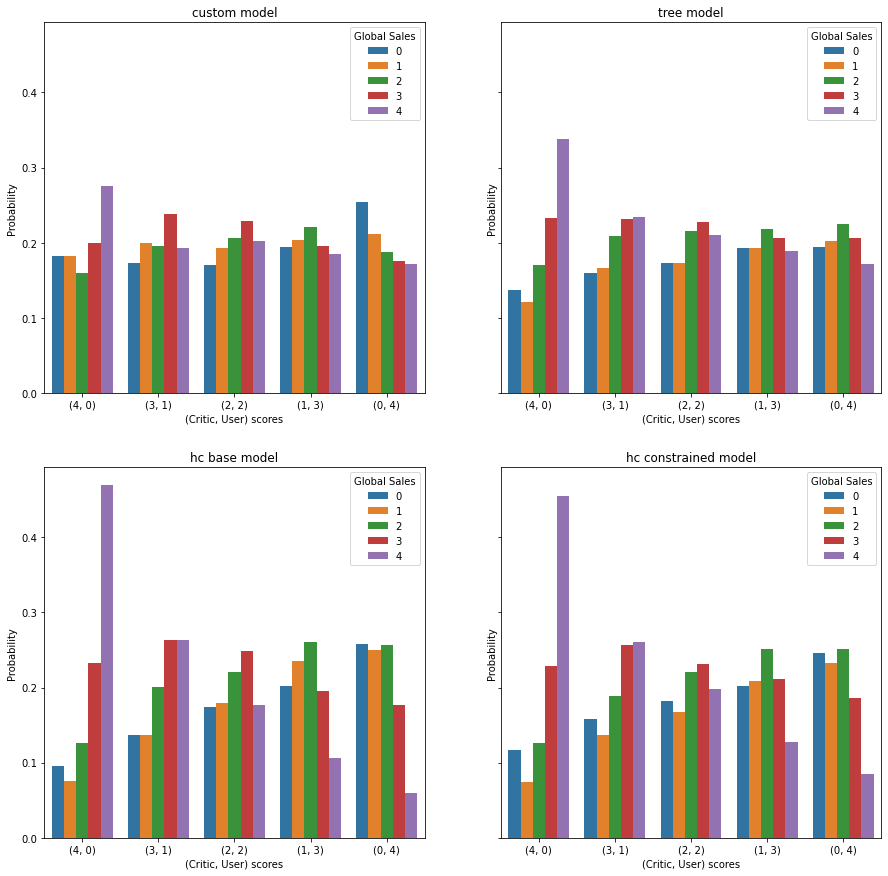

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()
for ax, name in zip(axes, answer_scores):
    ax.set_title(f"{name} model")
    probs = pd.DataFrame([[scores, int(sales), float(prob)] 
                          for scores in answer_scores[name]
                          for sales, prob in enumerate(answer_scores[name][scores])], 
                         columns=['(Critic, User) scores', 'Global Sales', 'Probability'])
    sns.barplot(x="(Critic, User) scores", y="Probability", hue="Global Sales", data=probs, ax=ax)
fig.savefig('query1')

### **Answer**
    The four models produce different results in terms of absolute values of the resulting probability distribution; in particular, the custom model produces more "uniform" distributions compared to the more "pointy" distributions of the hc models, with the tree model somewhere in between. Still, there is a clear pattern emerging from this scenarios and which all models agree on, namely the fact that an higher critic score seems to be more important in obtaining an higher volume of sales.

### **Question**
    Which platforms should a certain developer choose to develop a game in 2016?

In [14]:
platforms = ['PS4', 'PS3', 'PS2', 'PC', 'XOne', 'X360', '3DS']
answer_platforms = {}
evidence = {"Developer": "Ubisoft", "Year": 2016, "Publisher": "Ubisoft"}
print(f"Scenario: Ubisoft develops and publishes a game in 2016")
print(f"Possible platforms: {platforms}")
for name, ve in inferences:
    answer_platforms[name] = {}
    print(f"Performing inference for model: {name}")
    for platform in platforms:
        evidence['Platform'] = platform
        answer_platforms[name][platform] = ve.query(["Global_Sales"], evidence, show_progress=False).values

Scenario: Ubisoft develops and publishes a game in 2016
Possible platforms: ['PS4', 'PS3', 'PS2', 'PC', 'XOne', 'X360', '3DS']
Performing inference for model: custom
Performing inference for model: tree
Performing inference for model: hc base
Performing inference for model: hc constrained


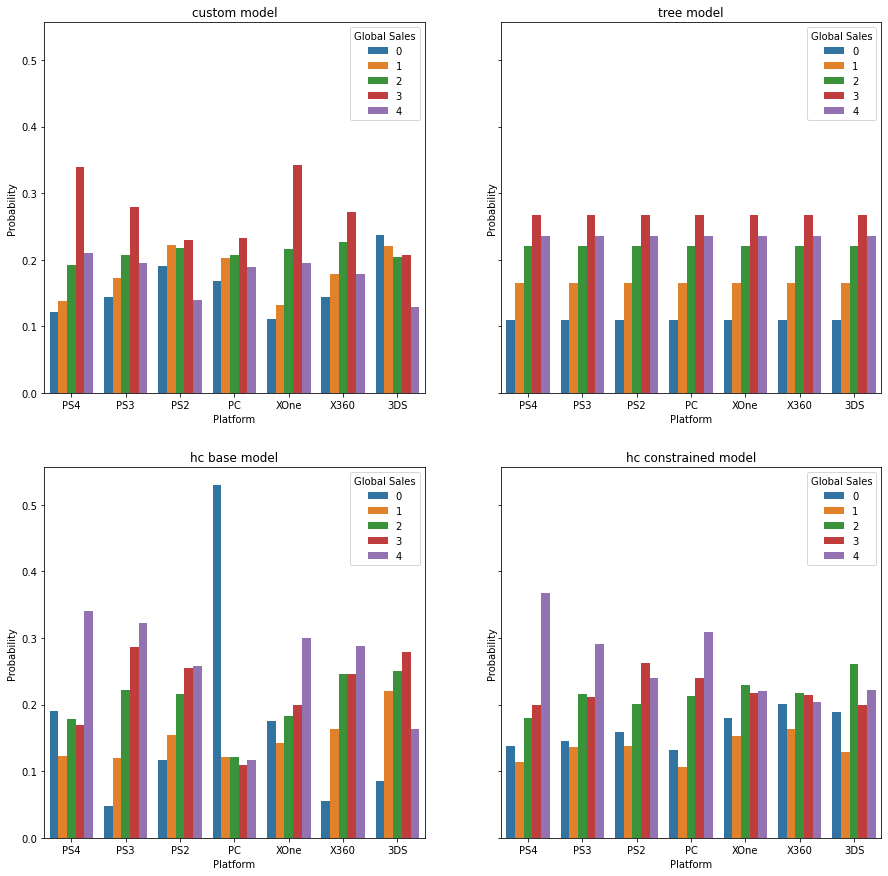

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()
for ax, name in zip(axes, answer_platforms):
    ax.set_title(f"{name} model")
    probs = pd.DataFrame([[plat, int(sales), float(prob)] 
                          for plat in answer_platforms[name]
                          for sales, prob in enumerate(answer_platforms[name][plat])], 
                         columns=['Platform', 'Global Sales', 'Probability'])
    sns.barplot(x="Platform", y="Probability", hue="Global Sales", data=probs, ax=ax)
fig.savefig('query2')

### Answer
    Again, the four models produce different results. The custom model suggests that it's a good idea for the developer to choose PS4 and XOne as platforms in 2016, an insight that is confirmed by the HC base model and partly (only for PS4) by the HC constrained model - which makes sense given that they were the newest platforms available in 2016. Moreover, we notice a lot of disagreement among the different models for the PC platform, with HC base suggesting it would be a flop whereas HC constrained suggests it would be a moderate success. This disagreement can maybe be explained by the fact that there is a lot uncertainty associated with this particular query - something that is highlighted by the almost-uniform distribution returned by the custom model.
    Finally, we can notice that the tree model, for this set of queries, always returns the same distribution. This is due to the structure of the network, which implies a conditional independence relationship between Global_Sales and Platform given Developer (certainly, an unrealistic assumption). As a sanity check, let's verify that indeed this conditional independence assertion holds:

In [16]:
def check_independence(model, v_independent, v_from, v_evidence):
    assertion = IndependenceAssertion(v_independent, v_from, v_evidence)
    print(f'Checking whether the following independence assertion holds:\n', assertion, sep='')
    v_independent = frozenset(v_independent)
    v_from = frozenset(v_from)
    v_evidence = frozenset(v_evidence)
    ind = [a for a in model.get_independencies().get_assertions() 
           if v_independent == a.event1 and v_from <= a.event2 and v_evidence == a.event3]
    if ind:
        if ind[0].event2 == v_from:
            print(f'The assertion holds.')
        else:
            print(f'A larger independence assertion (which includes the given one) holds in the given model:\n{ind[0]}')
    else:
        print(f'The assertion does not hold.')
    print()

check_independence(tree_model, ['Global_Sales'], ['Platform'], ['Developer'])
check_independence(tree_model, ['Global_Sales'], ['Developer'], ['Platform'])

Checking whether the following independence assertion holds:
(Global_Sales ⟂ Platform | Developer)
A larger independence assertion (which includes the given one) holds in the given model:
(Global_Sales ⟂ User_Score, JP_Sales, Publisher, Critic_Score, Year, Platform, Genre | Developer)

Checking whether the following independence assertion holds:
(Global_Sales ⟂ Developer | Platform)
The assertion does not hold.



### Question
    Which game genre tends to result in higher critic scores for a certain platform? 

In [17]:
genres = ['Sports', 'Racing', 'Platform', 'Misc', 'Action', 'Puzzle', 'Shooter',
          'Simulation', 'Role-Playing', 'Adventure']
answer_critics = {}
evidence = {"Platform": "PC"}
print(f"Scenario: platform is PC, genres: {genres}")
for name, ve in inferences:
    print(f"Performing inference for model: {name}")
    answer_critics[name] = {}
    for genre in genres:
        evidence["Genre"] = genre
        answer_critics[name][genre] = ve.query(["Critic_Score"], evidence, show_progress=False).values

Scenario: platform is PC, genres: ['Sports', 'Racing', 'Platform', 'Misc', 'Action', 'Puzzle', 'Shooter', 'Simulation', 'Role-Playing', 'Adventure']
Performing inference for model: custom
Performing inference for model: tree
Performing inference for model: hc base
Performing inference for model: hc constrained


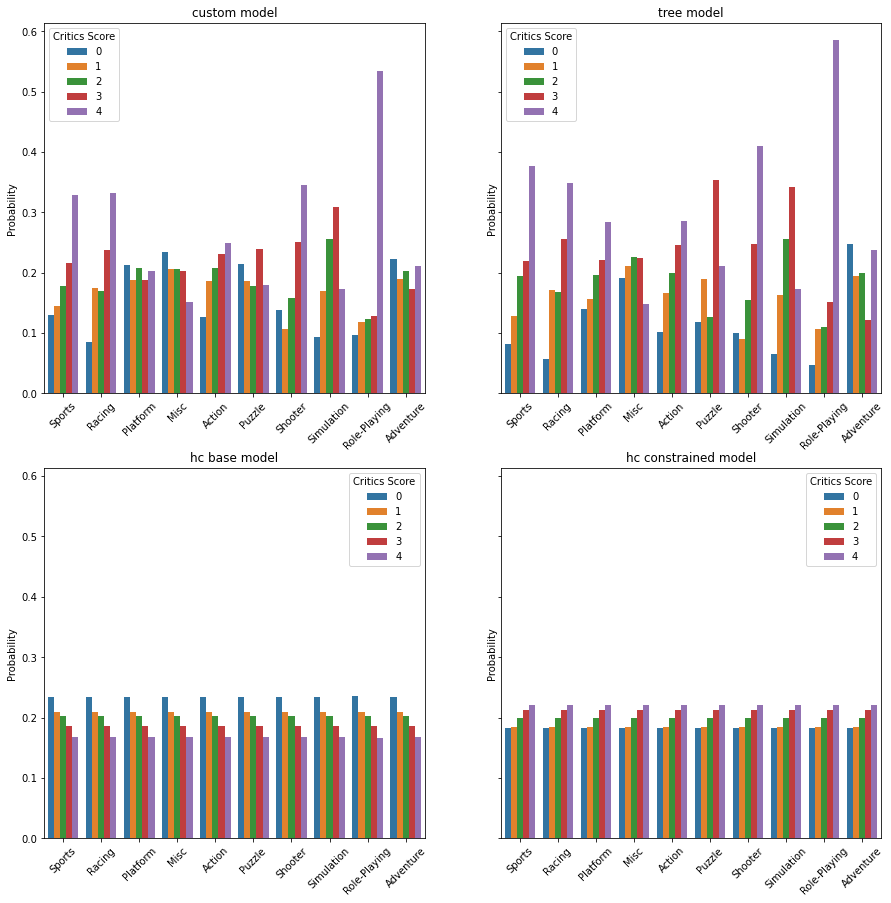

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()
for ax, name in zip(axes, answer_critics):
    ax.set_title(f"{name} model")
    probs = pd.DataFrame([[genre, int(score), float(prob)] 
                          for genre in answer_critics[name]
                          for score, prob in enumerate(answer_critics[name][genre])], 
                         columns=['Genre', 'Critics Score', 'Probability'])
    bp = sns.barplot(x="Genre", y="Probability", hue="Critics Score", data=probs, ax=ax)
    for label in bp.get_xticklabels():
        label.set_rotation(45)
    ax.set_xlabel('')
fig.savefig('query3')

### Answer
    The custom model and the tree model produce very similar results, with Role-Playing games being the most likely to receive high critic scores for PC platform, followed by Shooter, Sports and Racing games. 
    Moreover, similarly to what happened with previous queries to the tree model, the HC models return always the same distribution independently on the value of Genre. Like before, in the following cells we check whether a conditional independence relationship holds between Critic_Score and Genre, given Platform. Strangely, we can see that the independence holds only for the HC constrained model, and not for the HC base (as a sanity check, we also check the d-separation between nodes), so the result is most likely due to the poor quality of that model.

In [19]:
print('HC base')
check_independence(hc_base_model, ['Critic_Score'], ['Genre'], ['Platform'])
print('HC constrained')
check_independence(hc_constr_model, ['Critic_Score'], ['Genre'], ['Platform'])

HC base
Checking whether the following independence assertion holds:
(Critic_Score ⟂ Genre | Platform)
The assertion does not hold.

HC constrained
Checking whether the following independence assertion holds:
(Critic_Score ⟂ Genre | Platform)
A larger independence assertion (which includes the given one) holds in the given model:
(Critic_Score ⟂ User_Score, Developer, Publisher, Year, Genre | Platform)



In [20]:
def is_dseparated(model, start, end, observed):
    reachable = model.active_trail_nodes([start], observed)
    return end not in reachable[start]

print(f"'Critic_Score' is d-separated from 'Genre' given 'Platform' in HC base model: {is_dseparated(hc_base_model, 'Critic_Score', 'Genre', ['Platform'])}")
print(f"'Critic_Score' is d-separated from 'Genre' given 'Platform' in HC constrained model: {is_dseparated(hc_constr_model, 'Critic_Score', 'Genre', ['Platform'])}")

'Critic_Score' is d-separated from 'Genre' given 'Platform' in HC base model: False
'Critic_Score' is d-separated from 'Genre' given 'Platform' in HC constrained model: True
